**Author: Alexander Kollmann, 12/2022**

---

**Funktion**

InfluxDBv2 - Schreiben und Lesen
* InfluxDB Web-GUI
* Grafana

---



**Referenzen**

https://github.com/influxdata/influxdb-client-python



---

In [ ]:
# installieren der notwendigen Bibliotheken um auf InfluxDB zugreifen zu können
pip install influxdb-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 719 kB 7.6 MB/s 
     |████████████████████████████████| 140 kB 59.9 MB/s 
     |████████████████████████████████| 217 kB 52.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.13 which is incompatible.


In [ ]:
import requests
import influxdb_client, os, time
import pandas as pd
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS

/usr/local/lib/python3.8/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [ ]:
token='uv49TUnBaAUvGYS7p00JRixT10dA0iQmKLr95BAXRBO7OowrVHJuXdEuW2ecsxz0xRBdXnEZVVkPwDboFjDh8Q=='
bucket="test2"
org = "fh.wrnstd@gmail.com"
url = "https://us-east-1-1.aws.cloud2.influxdata.com"

client = influxdb_client.InfluxDBClient(url=url, token=token, org=org)


# Datenpunkt schreiben

In [ ]:
# 5 Datenpunkte schreiben

write_api = client.write_api(write_options=SYNCHRONOUS)
   
for value in range(5):
  point = (
    Point("measurement1")
    .tag("tagname1", "tagvalue1")
    .tag("tagname2", "tagvalue2")
    .field("field1", value)
  )
  write_api.write(bucket=bucket, org="fh.wrnstd@gmail.com", record=point)
  time.sleep(1) # separate points by 1 second


# Zeitserie (Monitoring)

In [ ]:
# CSV von URL laden (10 Patienten, versch. Parameter)

url_data = "https://raw.githubusercontent.com/alexontour/snippets/main/testdata/pat_timeseries_data.csv"

df=pd.read_csv(url_data, sep=";")
df['ts'] = pd.to_datetime(df['ts'])

df.head()

#df.describe()
#df.dtypes

,pat,hr,sys,dia,steps,ts
0,pat1,60,154,87,4559,2022-12-01 23:59:59+00:00
1,pat1,60,152,83,14487,2022-12-02 23:59:59+00:00
2,pat1,61,100,81,13911,2022-12-03 23:59:59+00:00
3,pat1,89,148,119,14892,2022-12-04 23:59:59+00:00
4,pat1,70,137,114,4904,2022-12-05 23:59:59+00:00


In [ ]:
# Write data to InfluxDB
with InfluxDBClient(url=url, token=token, org=org) as client:
   #df = df
   client.write_api(write_options=SYNCHRONOUS).write(bucket=bucket,record=df,
       data_frame_measurement_name="patts",
       data_frame_tag_columns=["pat"],
       data_frame_timestamp_column="ts")

In [ ]:
# Zeitserie - Garmin export

url_data = "https://raw.githubusercontent.com/alexontour/snippets/main/testdata/demo_activity_heartrate.csv"

df=pd.read_csv(url_data, sep=",")
df['Time'] = pd.to_datetime(df['Time'])
#df['Time'] = df['Time'] + pd.Timedelta(days=1887)
df['pat'] = 'alex'
df['uc'] = 'demo'
df.rename(columns = {'Time':'ts', 'HeartRateBpm':'hr'}, inplace = True)

df.head()

#df.describe()
#df.dtypes

,ts,DistanceMeters,hr,pat,uc
0,2022-11-24 16:51:38+00:00,0.0,106,alex,demo
1,2022-11-24 16:51:39+00:00,0.0,104,alex,demo
2,2022-11-24 16:51:40+00:00,0.0,105,alex,demo
3,2022-11-24 16:51:43+00:00,0.0,104,alex,demo
4,2022-11-24 16:51:44+00:00,0.0,106,alex,demo


In [ ]:
# Write data to InfluxDB
with InfluxDBClient(url=url, token=token, org=org) as client:
   #df = df
   client.write_api(write_options=SYNCHRONOUS).write(bucket=bucket,record=df,
       data_frame_measurement_name="garmin",
       data_frame_tag_columns=["uc","pat"],
       data_frame_timestamp_column="ts")

# Zeitserie (Herzrate)

In [ ]:
# CSV von URL laden

url_data = "https://raw.githubusercontent.com/alexontour/snippets/main/testdata/ID_1003_heartrate_1min_20171001_20171007.csv"

df=pd.read_csv(url_data, sep=",")
df['Time'] = pd.to_datetime(df['Time'])
# Tage hinzufügen um eine akutelle Zeitserie zu bekommen, da der InfluxDB-Demoaccount nur 30 Tage rückwirkend erlaubt
df['Time'] = df['Time'] + pd.Timedelta(days=1887)
df['pat'] = 'pat'
df['uc'] = 'demo'
df.rename(columns = {'Time':'ts', 'Value':'hr'}, inplace = True)

df.head()

,ts,hr,pat,uc
0,2022-12-01 00:00:00,58,pat,demo
1,2022-12-01 00:01:00,56,pat,demo
2,2022-12-01 00:02:00,54,pat,demo
3,2022-12-01 00:03:00,54,pat,demo
4,2022-12-01 00:04:00,53,pat,demo


In [ ]:
# Write data to InfluxDB
with InfluxDBClient(url=url, token=token, org=org) as client:
   df = df
   client.write_api(write_options=SYNCHRONOUS).write(bucket=bucket,record=df,
       data_frame_measurement_name="patts",
       data_frame_tag_columns=["pat", "uc"],
       data_frame_timestamp_column="ts")

Screenshot - InfluxDB (https://us-east-1-1.aws.cloud2.influxdata.com/)


1.   Login
2.   Data Explorer
3.   Zeitserie auswählen, Zeit-Range auswählen (bitte beachten, dass beim InfluxDB-Demo-Account nur ein Rückblick auf die letzten 30 Tage möglich ist)

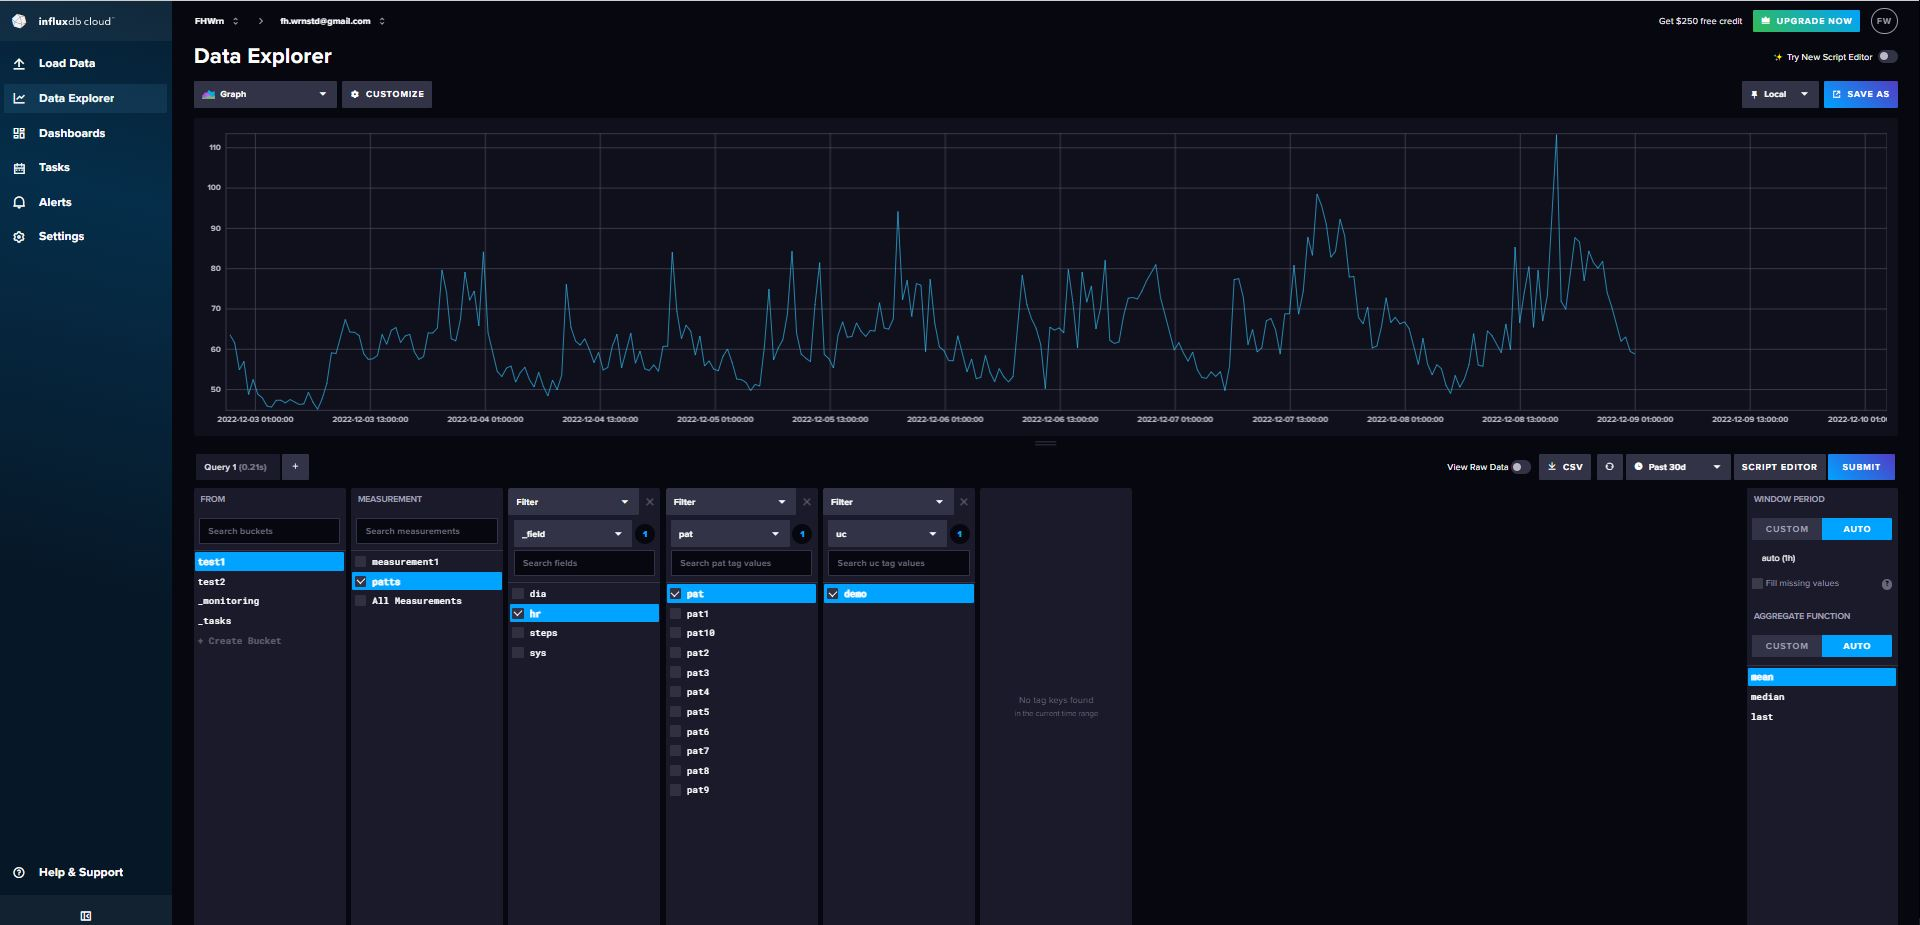

# Abfrage

## Flux - Query




In [ ]:
# Query

query= '''
from(bucket: "test1")
|> range(start:-30d, stop: now())
|> filter(fn: (r) => r._measurement == "patts")
|> filter(fn: (r) => r.pat == "pat1")
|> filter(fn: (r) => r._field == "hr")'''

#client = InfluxDBClient(url=url, token=token, org=org, debug=False)
#df_query = client.query_api().query_data_frame(org=org, query=query)
#df_query.head()

client = InfluxDBClient(url=url, token=token)

query_api = client.query_api()
result = query_api.query(org=org, query=query)
results = []
for table in result:
    for record in table.records:
        results.append((record.get_value(), record.get_field(), record.get_time()))
print(results)



[(60, 'hr', datetime.datetime(2022, 12, 2, 23, 59, 59, tzinfo=tzlocal())), (92, 'hr', datetime.datetime(2022, 12, 3, 13, 59, 59, tzinfo=tzlocal())), (61, 'hr', datetime.datetime(2022, 12, 3, 23, 59, 59, tzinfo=tzlocal())), (101, 'hr', datetime.datetime(2022, 12, 4, 13, 59, 59, tzinfo=tzlocal())), (89, 'hr', datetime.datetime(2022, 12, 4, 23, 59, 59, tzinfo=tzlocal())), (83, 'hr', datetime.datetime(2022, 12, 5, 13, 59, 59, tzinfo=tzlocal())), (70, 'hr', datetime.datetime(2022, 12, 5, 23, 59, 59, tzinfo=tzlocal())), (94, 'hr', datetime.datetime(2022, 12, 6, 13, 59, 59, tzinfo=tzlocal())), (59, 'hr', datetime.datetime(2022, 12, 6, 23, 59, 59, tzinfo=tzlocal())), (91, 'hr', datetime.datetime(2022, 12, 7, 13, 59, 59, tzinfo=tzlocal())), (62, 'hr', datetime.datetime(2022, 12, 7, 23, 59, 59, tzinfo=tzlocal())), (85, 'hr', datetime.datetime(2022, 12, 8, 13, 59, 59, tzinfo=tzlocal())), (59, 'hr', datetime.datetime(2022, 12, 8, 23, 59, 59, tzinfo=tzlocal())), (83, 'hr', datetime.datetime(2022, 1

## InfluxDB - WebGUI

Aufgabenstellung: Summe eines Paramters (STEPS) über einen gewissen Zeitraum für einen Patienten (PAT) ermitteln.

* im Bucket **test1** den **PAT1** und *STEPS* ausgewählt
* das gewünschte Zeitfenster einstellen (10.12.2022 00:00 bis 13.12.2022 00:00) - UTC Zeit einstellen (rechts oben)
* Tipp: Darstellung Tabelle wählen (links oben unter Data Explorer), View Raw Data wählen (Schalter rechts unten) -> somit sieht man die 6 Einträge

> ![picture](https://raw.github.com/alexontour/snippets/main/screenshots/snip_influxdb_1.JPG)

* Window-Period auf *CUSTOM* jedenfalls > 3 Tage stellen und *AGGREGATE-Funktion* auf "*sum*". Die ausgewählte AGGREGATE-Funktion wird auf alle Werte innerhalb des Windows angewendet. Im Beispiel wurde für die Window-Period 7 Tage (7d) genommen. Submit drücken.
* jetzt sieht man in der Tabelle in der Spalte "_value" den Wert 48449 (= Summe über die ausgewählte Periode)

> ![picture](https://raw.github.com/alexontour/snippets/main/screenshots/snip_influxdb_2.JPG)


* Tipp: bessere Darstellung: unter Data-Explorer "Single Stat" auswählen (-> nicht vergessen "view raw data" wieder auszuschalten)

> ![picture](https://raw.github.com/alexontour/snippets/main/screenshots/snip_influxdb_3.JPG)

## Grafana - WebGUI

Grafana (https://fhwrnstd.grafana.net/)

1.   InfluxDB als Datenquelle hinzufügen
2.   Dashbaord erstellen   
3.   Dashboards im Überblick (Pat 1 & Pat 2)


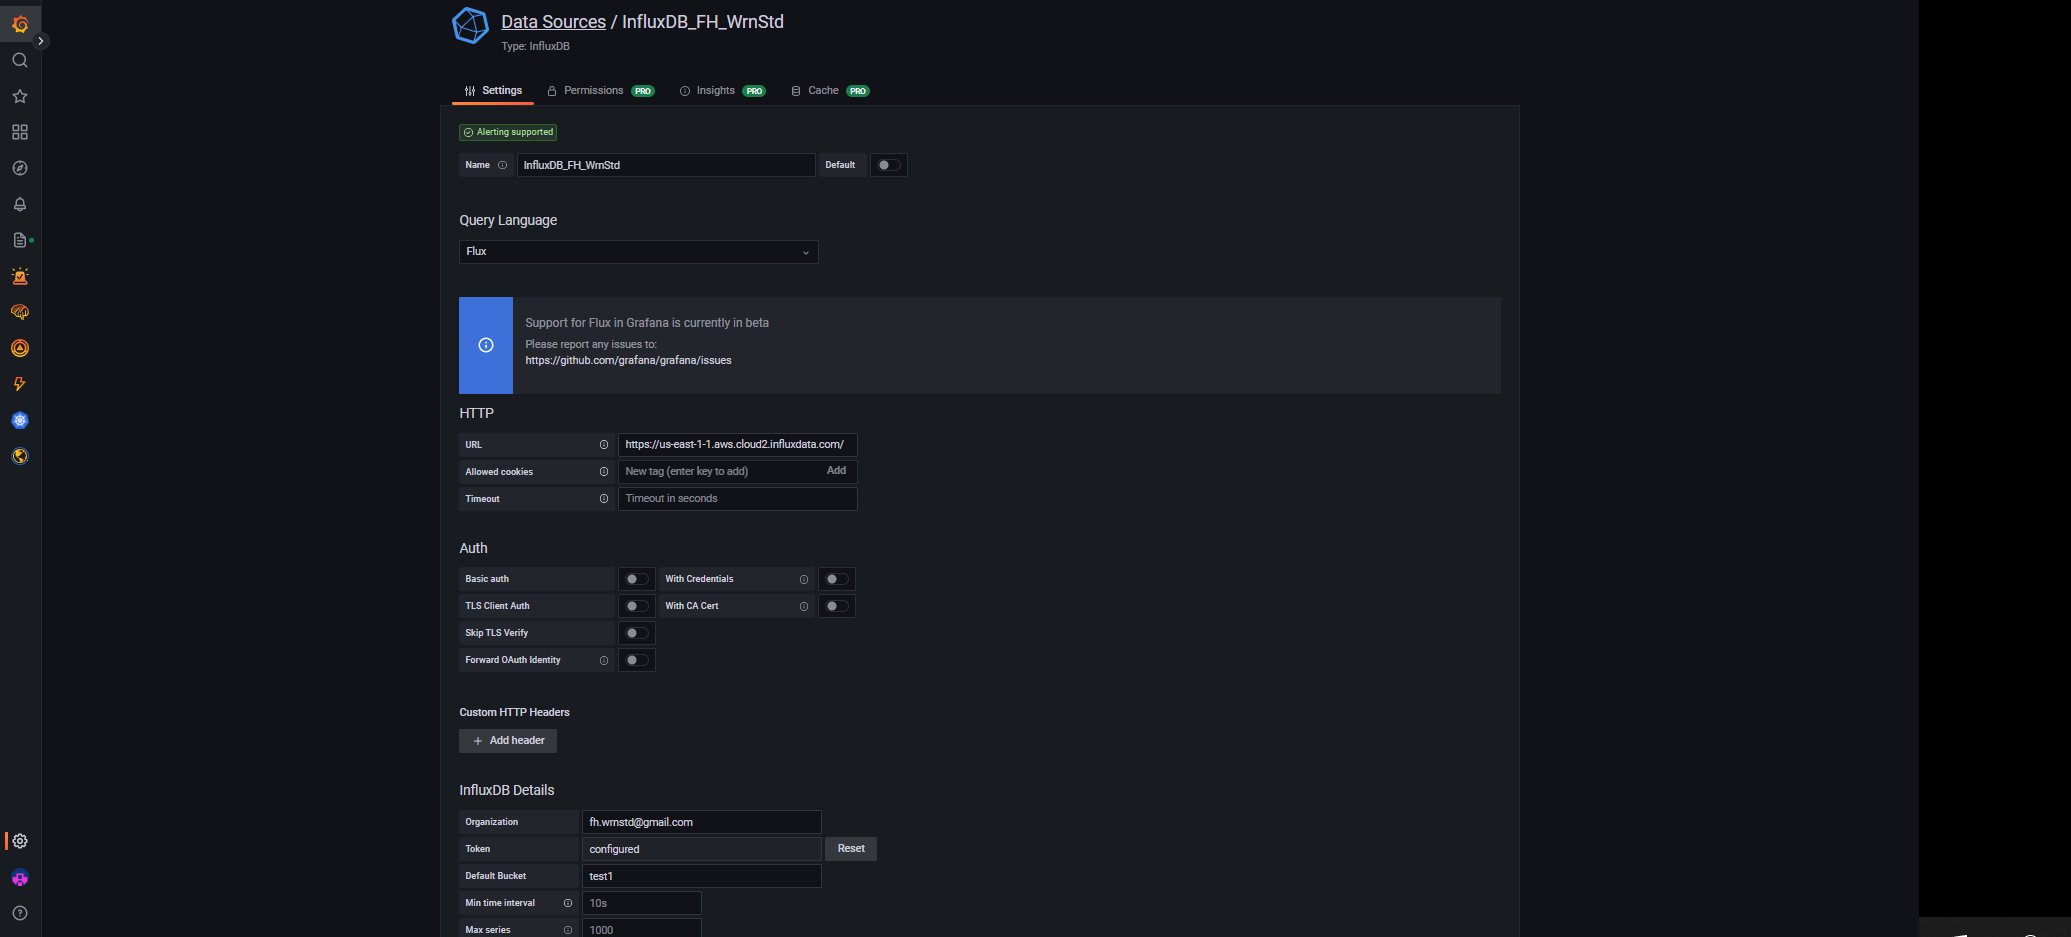

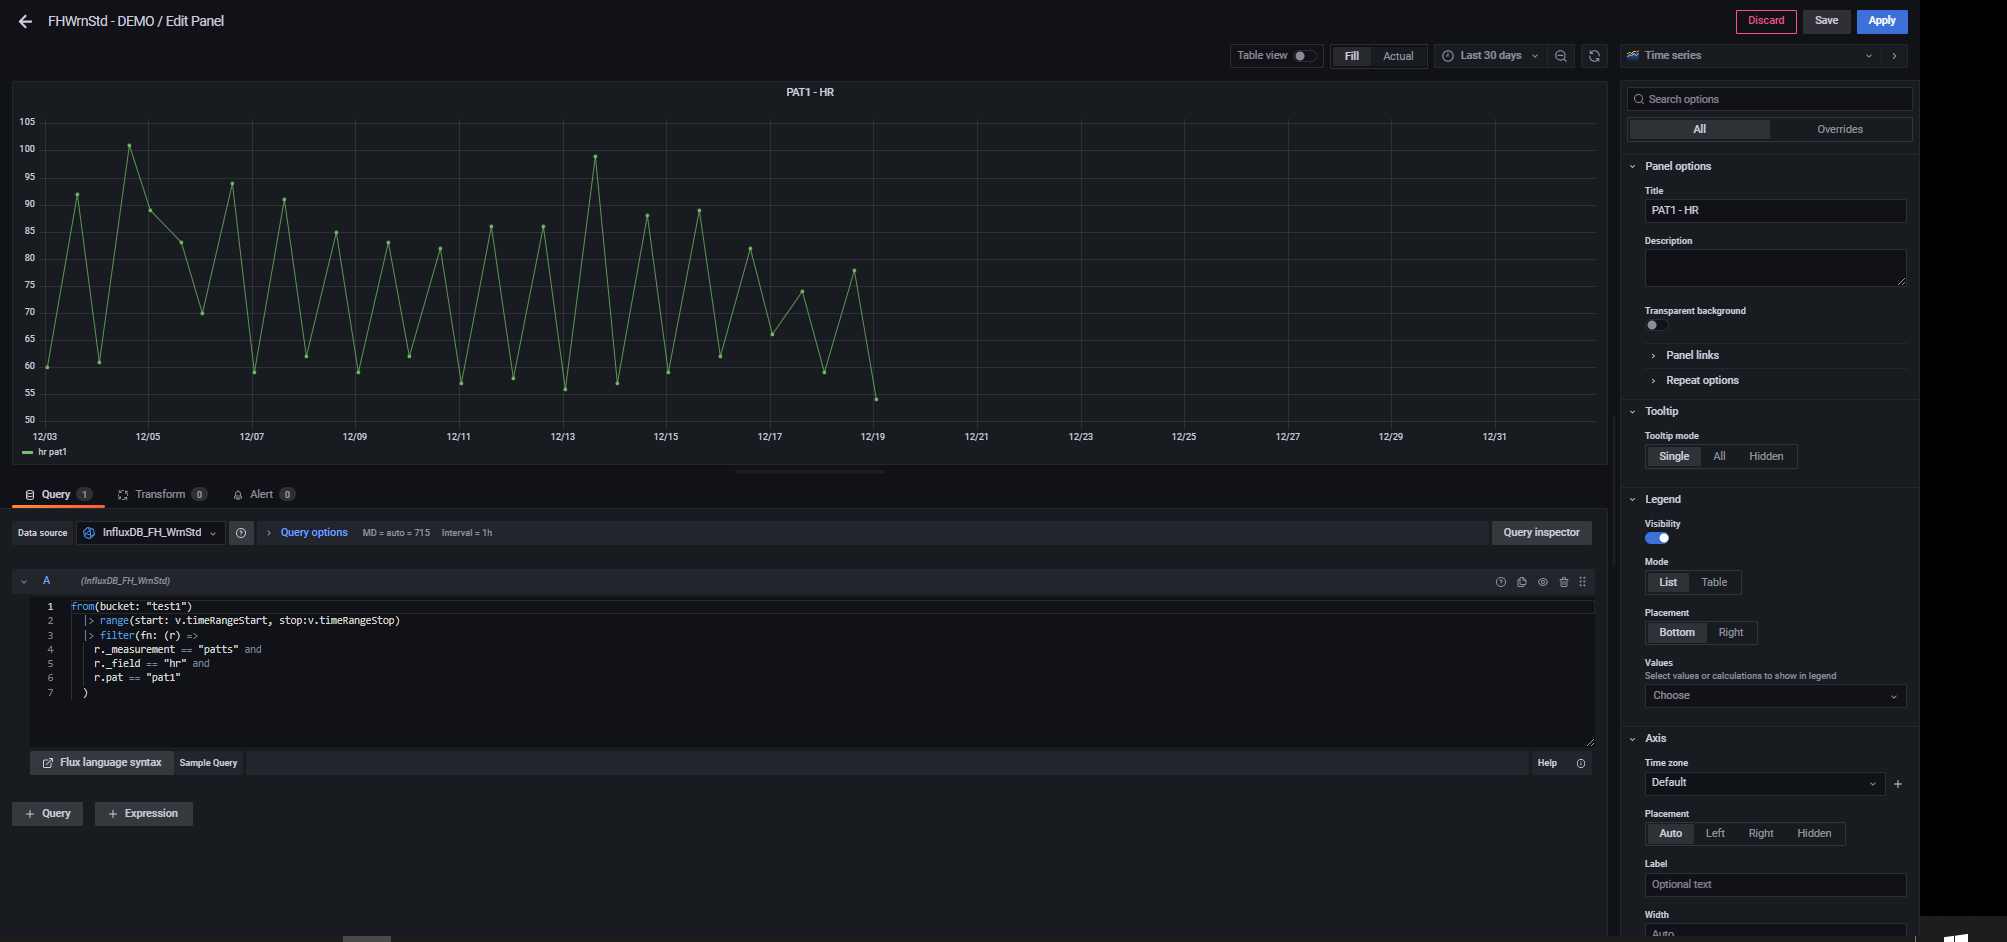


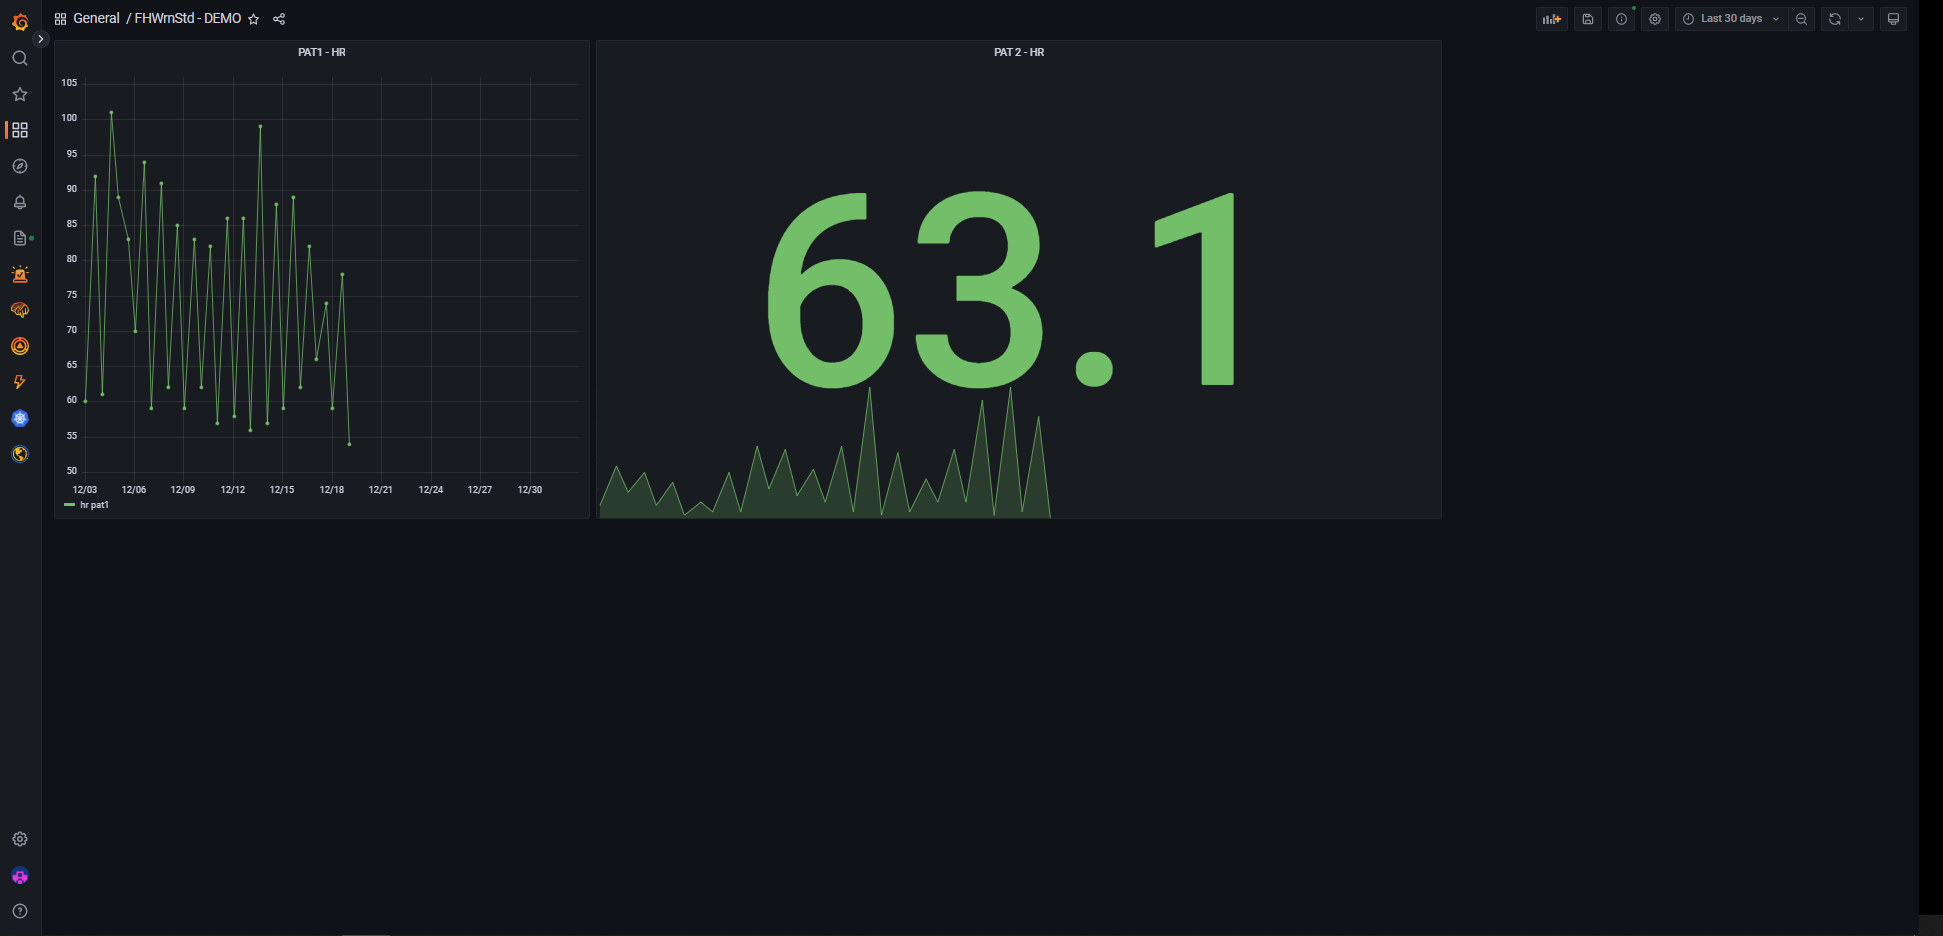